In this notebook I will retrain a CNN in order to identify a picture as one of 3 different dog breeds: bergamasco shepard, dalmation, or dauschund.

In [35]:
# Load modules
from fastai.vision import *
from fastai.widgets import *
from fastai.metrics import error_rate
from google_images_download import google_images_download
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import pickle

# Set seed
np.random.seed(2)

In [36]:
# Breeds to identify
with open(os.getcwd() + '/breeds/breeds.pkl', 'rb') as f:
    breeds = pickle.load(f)
    
# Identify path
path = Path('dogs')

Acquire images by searching for the specific breed you want pictures of on google images. Create a file with urls for images of the breed by following these instructions:

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [37]:
# Create Labels and pull data
for breed in breeds:
    folder = breed
    file = 'urls_{}.csv'.format(breed)
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(path/file, dest, max_pics=400)

In [38]:
# Delete bad images
for breed in breeds:
    verify_images(path/breed, delete=True, max_size=400)

In [39]:
db = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=299).normalize(imagenet_stats)

In [40]:
# Data classes
db.classes

['bergamasco shepard', 'dalmation', 'dauschund']

In [46]:
# Create learner
learn = cnn_learner(db, models.resnet50, metrics=error_rate)

In [47]:
# Train one cycle
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.341323,0.043518,0.016484,00:25


In [48]:
# Save model to disc
learn.save('model-v1')

This is very good for right off the bat - let's look and see where the model could be improved upon.

In [49]:
interp = ClassificationInterpretation.from_learner(learn)

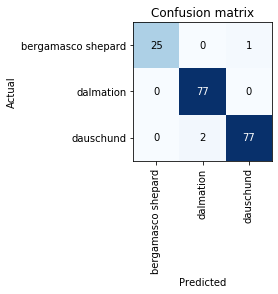

In [50]:
interp.plot_confusion_matrix()

The model thought one bergamasco shepard was a dauschund and two dauschunds were dalmations. Let's clean the training and validation sets and see if we can improve the model and potentially have a cleaner validation set as a result.

In [51]:
# Load all training and validation data for cleaning
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=299)
                   .databunch()
     )

In [52]:
# Load model
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)
learn_cln.load('model-v1');

In [53]:
# Indices of top losses
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [54]:
# Clean images (based upon image quality and breed relevance)
ImageCleaner(ds, idxs, path)

'No images to show :)'

In [55]:
# Only keep cleaned images (deleting from disk rather than working with cleaned.csv)
fp_cleaned = os.getcwd() + '/dogs/cleaned.csv'
cleaned = pd.read_csv(fp_cleaned)
fp_current = os.getcwd() + '/dogs/'
for breed in breeds:
    fp_breed = fp_current + breed
    current = os.listdir(fp_breed)
    for f in current:
        if breed + '/' + f not in list(cleaned.name):
            os.remove(fp_breed + '/' + f)
            
# Delete cleaned.csv
os.remove(fp_cleaned)

In [56]:
# Load all training and validation data to check for duplicates
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=299)
                   .databunch()
     )

In [57]:
# Load model
learn_cln = cnn_learner(db, models.resnet50, metrics=error_rate)
learn_cln.load('model-v1');

In [58]:
# Check for duplicates
ds, idxs = DatasetFormatter().from_similars(learn_cln)
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [59]:
# Delete duplicates (deleting from disk rather than working with cleaned.csv)
fp_cleaned = os.getcwd() + '/dogs/cleaned.csv'
cleaned = pd.read_csv(fp_cleaned)
fp_current = os.getcwd() + '/dogs/'
for breed in breeds:
    fp_breed = fp_current + breed
    current = os.listdir(fp_breed)
    for f in current:
        if breed + '/' + f not in list(cleaned.name):
            os.remove(fp_breed + '/' + f)
            
# Delete cleaned.csv
os.remove(fp_cleaned)

In [60]:
# Images per breed
min_pics = 1000
for breed in breeds:
    n = len(os.listdir(path/breed))
    min_pics = min(min_pics, n)
print('The number of pictures for each breed will be {}'.format(min_pics))

The number of pictures for each breed will be 111


In [61]:
# Balance the number of images between the classes
for breed in breeds:
    f = os.listdir(path/breed)
    n = len(f)
    for i in range(n):
        if i > min_pics - 1:
            os.remove(path/breed/f[i])

In [62]:
db = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=299).normalize(imagenet_stats)

In [63]:
# See classes (again)
db.classes

['bergamasco shepard', 'dalmation', 'dauschund']

In [64]:
# Make a new learner
learn = cnn_learner(db, models.resnet50, metrics=error_rate)

In [65]:
# Fit one cycle
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.027611,0.105739,0.030303,00:16


In [66]:
# Let all layers of network learn - not just the top
learn.unfreeze()

In [67]:
# Determine learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


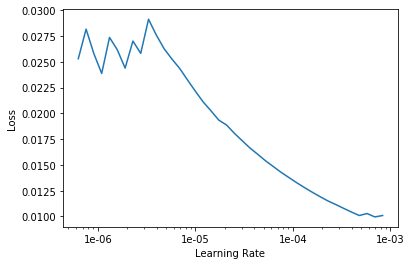

In [68]:
# Plot loss vs. learning rates
learn.recorder.plot()

In [70]:
# Train
learn.fit_one_cycle(1, max_lr=slice(8e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.046552,0.013904,0.000000,00:13


In [73]:
learn.save('model-v2')

This model achieved an error rate of 0.00 on the validation data. That's absolutely fantastic.  

This project was inspired by and much of the code sourced from [here](https://course.fast.ai/videos/?lesson=2).